In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()
Base = automap_base()


In [6]:
# * Use SQLAlchemy `automap_base()` to reflect your tables into classes and 
# save a reference to those classes called `Station` and `Measurement`.
# reflect an existing database into a new model

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
# Creating variable to hold the Measurement Class
Measurement = Base.classes.measurement
# Creating variable to hold the Station Class
Station = Base.classes.station



In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
# Reviewing the columns and types before querying off of them
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# query measurments where date is last 12 months, showing prpc, group by month

# Calculate the date 1 year ago from the last data point in the database

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date
# ('2017-08-23')

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()
results

# Save the query results as a Pandas DataFrame, drop null values, set the index to the date column and sort by date
prcpDF= pd.DataFrame(results)
prcpDF.dropna(how="any", inplace=True)
prcpDF.set_index("date", inplace=True)
prcpDF.sort_values(by=["date"], inplace=True, ascending=False)
prcpDF.head(5)


,prcp
date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.50


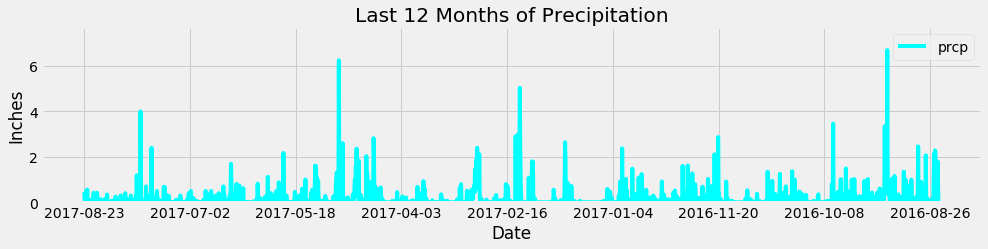

<Figure size 432x288 with 0 Axes>

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpDF.plot(kind="line", figsize=(15,3), color="aqua")
plt.ylim(0, max(prcpDF["prcp"])+1)

# Set a title for the chart
plt.title("Last 12 Months of Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")

plt.show()
plt.tight_layout()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_count
most_active_station = station_count[0][0]

print(f'The most active stations is {most_active_station} with {station_count[0][1]} readings.')
print(station_count)

The most active stations is USC00519281 with 2772 readings.
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

stats_for_USC00519281 = session.query(Measurement.station, 
                                    func.min(Measurement.tobs),\
                                    func.max(Measurement.tobs),\
                                    func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == most_active_station).all()
                                                                    
print(f'Most Active Station Number = {stats_for_USC00519281[0][0]}')
print(f'Min Temp = {stats_for_USC00519281[0][1]}')
print(f'Max Temp = {stats_for_USC00519281[0][2]}')
print(f'Avg Temp = {stats_for_USC00519281[0][3]}')

Most Active Station Number = USC00519281
Min Temp = 54.0
Max Temp = 85.0
Avg Temp = 71.66378066378067


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# temp_count = engine.execute('SELECT station, COUNT(tobs) FROM Measurement GROUP BY station ORDER BY count(tobs) DESC')

temp_count = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
most_tobs = temp_count[0][0]

print(f'The most active station with regards to temperature obsesrvations is also {most_tobs} with {temp_count[0][1]} readings.')
print(temp_count)


The most active station with regards to temperature obsesrvations is also USC00519281 with 2772 readings.
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [18]:
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == most_tobs).all()
temp_results

tobsDF= pd.DataFrame(temp_results)
tobsDF.dropna(how="any", inplace=True)
tobsDF.set_index("date", inplace=True)
tobsDF.sort_values(by=["date"], inplace=True, ascending=False)
tobsDF.head(5)

,tobs
date,
2017-08-18,79.0
2017-08-17,76.0
2017-08-16,76.0
2017-08-15,77.0
2017-08-14,77.0


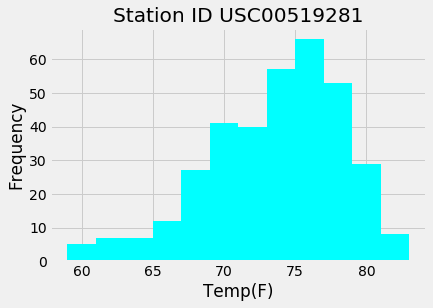

In [19]:
# Histogram of Temps for USC00519281

fig,ax = plt.subplots(1,1)
a = tobsDF["tobs"]
ax.hist(a, bins = 12, color='aqua')
ax.set_title("Station ID USC00519281")
ax.set_xlabel('Temp(F)')
ax.set_ylabel('Frequency')

plt.show()

# Bonus Challenge Assignments

### Temperature Analysis II

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d`. The function will return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

* Use the average temperature as the bar height.

* Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# MY TRIP DATES = START - "2011-06-20" , END - '2011-06-30'

year_ago_start_date = '2010-06-20'
year_ago_end_date = '2010-06-30'

# Using Calc Temps function to be used to create df for plot
vacay_calcTemps = calc_temps(year_ago_start_date, year_ago_end_date)
vacay_calcTemps

# Perform a query to retrieve the data and precipitation scores - for all vacation dates one year ago
vacay_results = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date <= year_ago_end_date).\
    filter(Measurement.date >= year_ago_start_date).\
    order_by(Measurement.date).all()
vacay_results

vacayDF= pd.DataFrame(vacay_results)
vacayDF.dropna(how="any", inplace=True)
vacayDF.set_index("date", inplace=True)
vacayDF.sort_values(by=["date"], inplace=True, ascending=False)

# Printing DF and Function results side by side to verify accuracy
vacayDF.describe(), vacay_calcTemps

(            prcp       tobs
 count  85.000000  85.000000
 mean    0.072941  75.047059
 std     0.162721   2.733853
 min     0.000000  69.000000
 25%     0.000000  73.000000
 50%     0.010000  75.000000
 75%     0.060000  77.000000
 max     0.880000  85.000000,
 [(69.0, 74.92134831460675, 85.0)])

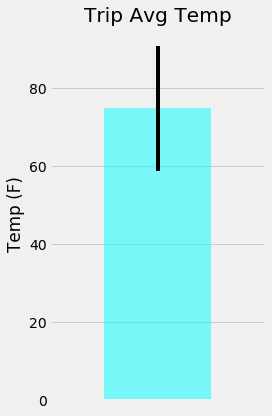

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

vacay_calcTempsDF= pd.DataFrame(vacay_calcTemps, columns=['tmin', 'tavg', 'tmax'])

y_err_calc = (vacay_calcTempsDF["tmax"] - vacay_calcTempsDF["tmin"])

vacay_calcTempsDF.plot.bar(y='tavg', yerr=y_err_calc, title='Trip Avg Temp', color='aqua', alpha=0.5, figsize=(4,6))

plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()



### Daily Rainfall Average
* Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

* You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic TOBS that match that date string.

* Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Create a table of total prcp by station. Create a DF that can be joineds with hawaii stations data
total_vacay_prcp = vacayDF.groupby("station")["prcp"].sum()
total_vacay_prcp.sort_values(axis=0, inplace=True, ascending=False)
rainfall_DF = pd.DataFrame(total_vacay_prcp)
rainfall_DF


,prcp
station,
USC00516128,3.23
USC00518838,0.86
USC00519281,0.69
USC00513117,0.50
USC00514830,0.44
USC00519523,0.16
USC00511918,0.16
USC00517948,0.14
USC00519397,0.02


In [24]:
#Query for station info and put into DF to be merged with rainfall_DF
station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_info_DF = pd.DataFrame(station_info)
station_info_DF

# Merging DF for final Vacation DF listing the station, name, latitude, longitude, and elevation, sorted by prcp

final_vacay_df = pd.merge(rainfall_DF, station_info_DF, on=["station"]) 
final_vacay_df

,station,prcp,name,latitude,longitude,elevation
0,USC00516128,3.23,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00518838,0.86,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
2,USC00519281,0.69,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00513117,0.50,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00514830,0.44,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519523,0.16,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00511918,0.16,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00517948,0.14,"PEARL CITY, HI US",21.39340,-157.97510,11.9
8,USC00519397,0.02,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip

trip_dates = ["06-20", "06-21", "06-22", "06-23", "06-24", "06-25", "06-26", "06-27", "06-28", "06-29", "06-30"]

for day in trip_dates:
    daily_normals(day)
    print(day, daily_normals(day))


06-20 [(68.0, 73.96491228070175, 85.0)]
06-21 [(68.0, 74.75862068965517, 82.0)]
06-22 [(69.0, 75.15789473684211, 81.0)]
06-23 [(68.0, 74.54385964912281, 80.0)]
06-24 [(68.0, 74.96428571428571, 84.0)]
06-25 [(68.0, 74.10344827586206, 80.0)]
06-26 [(67.0, 74.21428571428571, 82.0)]
06-27 [(66.0, 75.01785714285714, 81.0)]
06-28 [(69.0, 74.88679245283019, 80.0)]
06-29 [(67.0, 74.91525423728814, 80.0)]
06-30 [(67.0, 75.59615384615384, 81.0)]


In [27]:
#convert tuple into a list to create a dataframe
trip_dates = ["06-20", "06-21", "06-22", "06-23", "06-24", "06-25", "06-26", "06-27", "06-28", "06-29", "06-30"]

day_list = []
min_list = []
avg_list = []
max_list = []

for day in trip_dates:
    list(day)
    list(daily_normals(day))
    day_list.append(day)
    min_list.append(daily_normals(day)[0][0])
    avg_list.append(daily_normals(day)[0][1])
    max_list.append(daily_normals(day)[0][2])
    
print(day_list)
print(min_list)
print(avg_list)
print(max_list)

['06-20', '06-21', '06-22', '06-23', '06-24', '06-25', '06-26', '06-27', '06-28', '06-29', '06-30']
[68.0, 68.0, 69.0, 68.0, 68.0, 68.0, 67.0, 66.0, 69.0, 67.0, 67.0]
[73.96491228070175, 74.75862068965517, 75.15789473684211, 74.54385964912281, 74.96428571428571, 74.10344827586206, 74.21428571428571, 75.01785714285714, 74.88679245283019, 74.91525423728814, 75.59615384615384]
[85.0, 82.0, 81.0, 80.0, 84.0, 80.0, 82.0, 81.0, 80.0, 80.0, 81.0]


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame({"Date" : day_list,
                       "Min Temp" : min_list,
                        "Avg Temp" : avg_list,
                        "Max Temp" : max_list                       
                       })
trip_df = trip_df.set_index("Date")
trip_df

,Min Temp,Avg Temp,Max Temp
Date,,,
06-20,68.0,73.964912,85.0
06-21,68.0,74.758621,82.0
06-22,69.0,75.157895,81.0
06-23,68.0,74.543860,80.0
06-24,68.0,74.964286,84.0
06-25,68.0,74.103448,80.0
06-26,67.0,74.214286,82.0
06-27,66.0,75.017857,81.0
06-28,69.0,74.886792,80.0


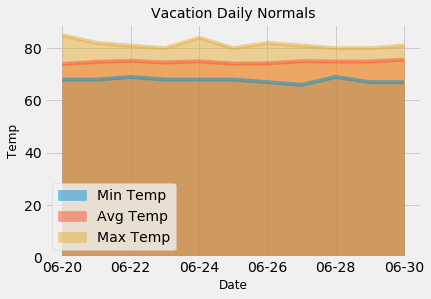

In [29]:
# Plot the daily normals as an area plot with `stacked=False`

trip_df.plot(kind='area', stacked=False)
plt.title("Vacation Daily Normals", size=14)
plt.ylabel("Temp", size = 12)
plt.xlabel("Date", size = 12)
plt.show(block=True)